In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn
import matplotlib
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics

In [2]:
STOCK = "TTRAK.IS"
PERIOD_HISTORY = "5y"
PERIOD_ESTIMATION = 90
PERIOD_CV = "15 days"
PERIOD_HORIZON = "180 days"

In [3]:
tick = yf.Ticker(STOCK)

In [4]:
hist = tick.history(period=PERIOD_HISTORY, actions=False)
hist["Date"] = hist.index
hist = hist.set_index([[i for i in range(len(hist))]])

In [5]:
hist.head(5)

,Open,High,Low,Close,Volume,Date
0,53.324222,53.635833,52.662052,52.973663,66460,2016-01-08
1,52.973663,53.363176,52.778907,52.973663,28798,2016-01-11
2,53.285269,54.375905,52.934705,53.908485,53040,2016-01-12
3,54.142199,55.700248,54.142199,55.544445,161151,2016-01-13
4,55.622347,55.700248,54.375909,54.531712,105572,2016-01-14


In [6]:
hist.describe()["Close"]

count    1292.000000
mean       61.631917
std        25.355872
min        23.985819
25%        43.727330
50%        63.433870
75%        69.703125
max       193.000000
Name: Close, dtype: float64

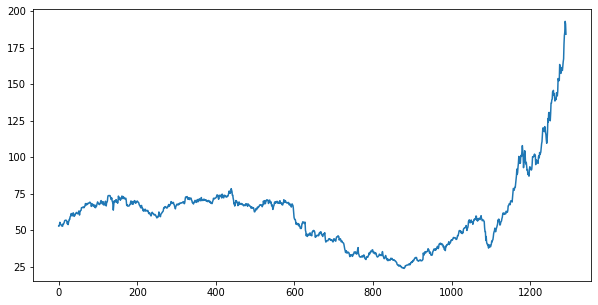

In [7]:
hist["Close"].plot(figsize=(10, 5))

plt.savefig("out/stock_prices.png")

In [8]:
data = hist[["Date", "Close"]]
data = data.rename(columns={"Date": "ds", "Close": "y"})

data.head(5)

,ds,y
0,2016-01-08,52.973663
1,2016-01-11,52.973663
2,2016-01-12,53.908485
3,2016-01-13,55.544445
4,2016-01-14,54.531712


In [9]:
df_train = data[0:int(len(data)-(PERIOD_ESTIMATION/2))]

In [10]:
model = Prophet()
model.add_country_holidays(country_name="TR")
model.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
future = model.make_future_dataframe(periods=PERIOD_ESTIMATION)

future["day"] = future["ds"].dt.weekday
future = future[future["day"] <= 4]

In [12]:
preds = model.predict(future)
preds[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(5)

,ds,yhat,yhat_lower,yhat_upper
1306,2021-01-28,121.816946,115.493594,128.450049
1307,2021-01-29,121.886908,115.431513,128.701827
1308,2021-02-01,122.291555,115.794777,128.828759
1309,2021-02-02,122.575253,116.431569,129.131267
1310,2021-02-03,122.613201,116.017869,129.121493


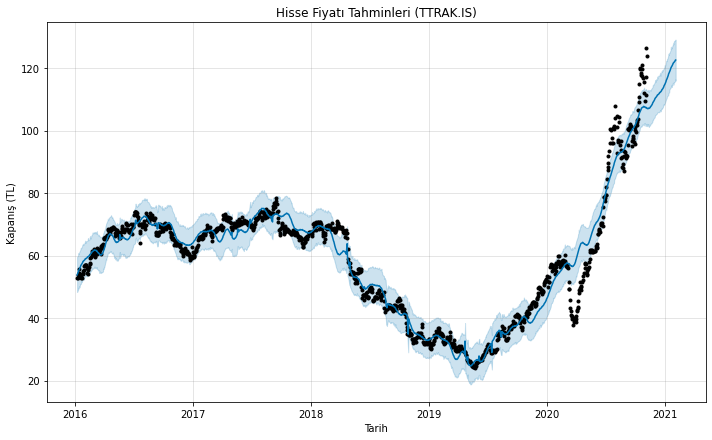

In [13]:
model.plot(preds)

plt.title("Hisse Fiyatı Tahminleri ({})".format(STOCK))
plt.xlabel("Tarih")
plt.ylabel("Kapanış (TL)")
plt.show()

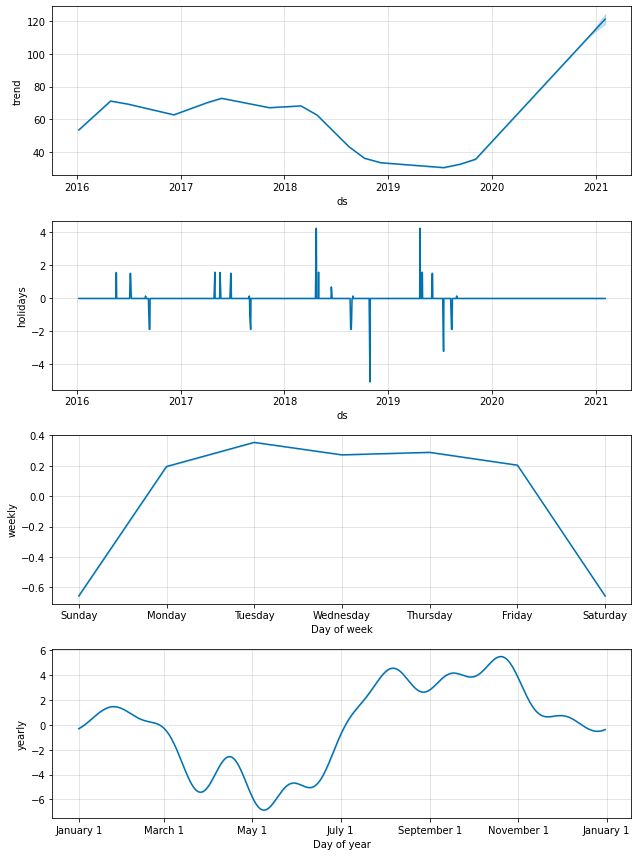

In [14]:
model.plot_components(preds)
plt.show()

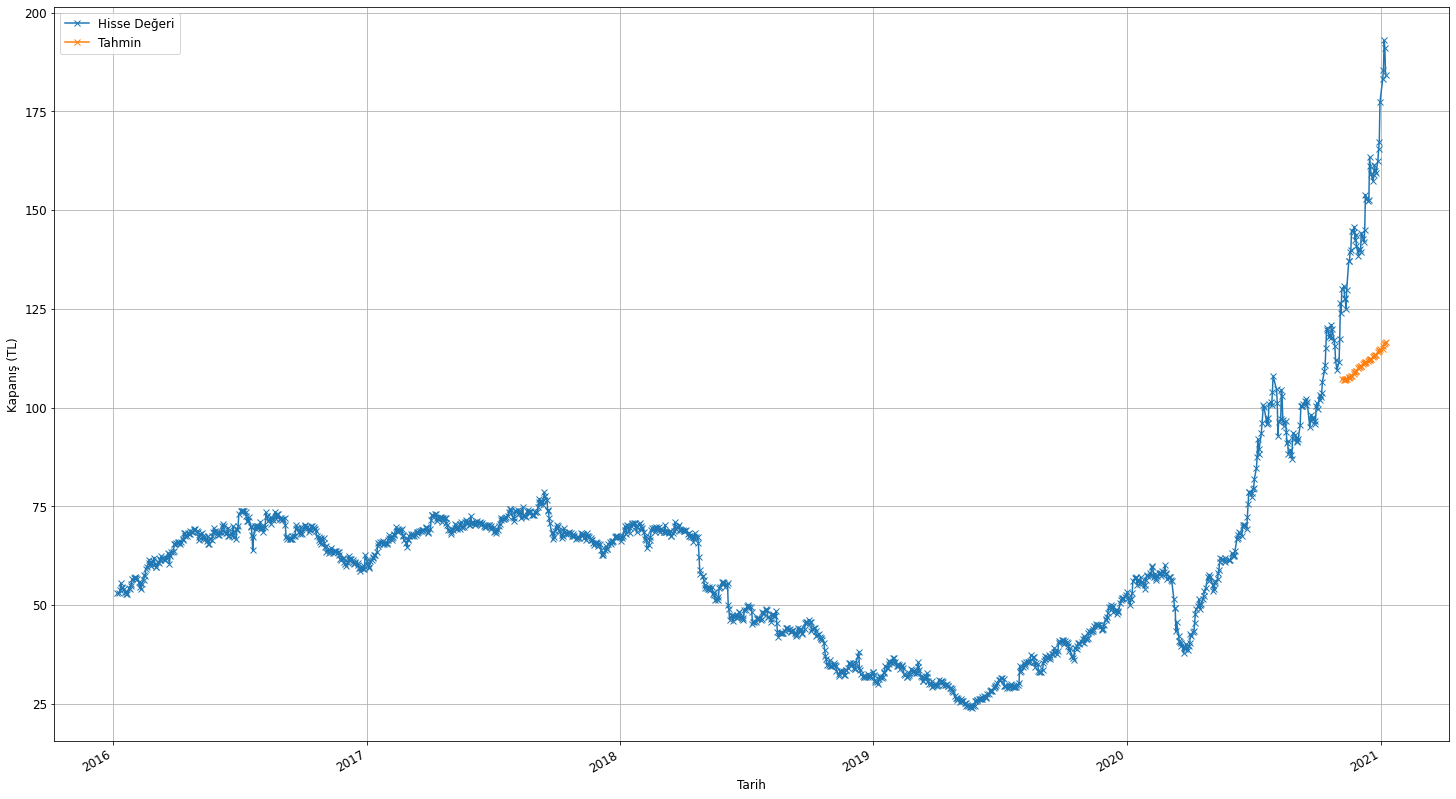

In [15]:
matplotlib.rcParams["figure.figsize"] = 25, 15
matplotlib.rcParams.update({"font.size": 12})

ax = data.plot(x="ds", y="y", style="x-", grid=True)

ax.plot(
    data["ds"][len(df_train):int(len(df_train)+(PERIOD_ESTIMATION/2))], 
    preds["yhat"][len(df_train):int(len(df_train)+(PERIOD_ESTIMATION/2))], 
    marker="x"
)
    
ax.set_xlabel("Tarih")
ax.set_ylabel("Kapanış (TL)")
ax.legend(["Hisse Değeri", "Tahmin"])

plt.savefig("out/stock_estimates.png")

In [16]:
cv = cross_validation(model, period=PERIOD_CV, horizon=PERIOD_HORIZON, parallel="processes")

cv.head(5)

INFO:fbprophet:Making 70 forecasts with cutoffs between 2017-07-09 00:00:00 and 2020-05-09 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x1353bdee0>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-07-10,70.292857,68.926591,71.634502,68.994583,2017-07-09
1,2017-07-11,70.204596,68.762603,71.706855,69.968834,2017-07-09
2,2017-07-12,70.071756,68.793993,71.517531,70.633087,2017-07-09
3,2017-07-13,69.786386,68.351094,71.243671,72.005898,2017-07-09
4,2017-07-14,69.769742,68.222963,71.177652,71.474487,2017-07-09


In [17]:
pm = performance_metrics(cv)

pm.head(5)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,18 days,30.167124,5.492461,4.015903,0.090642,0.065204,0.338964
1,19 days,31.053236,5.572543,4.134573,0.093135,0.068593,0.318740
2,20 days,32.104933,5.666122,4.235433,0.095273,0.072147,0.304054
3,21 days,34.093250,5.838943,4.350666,0.097860,0.072978,0.298108
4,22 days,36.271957,6.022620,4.467023,0.100514,0.073991,0.296149


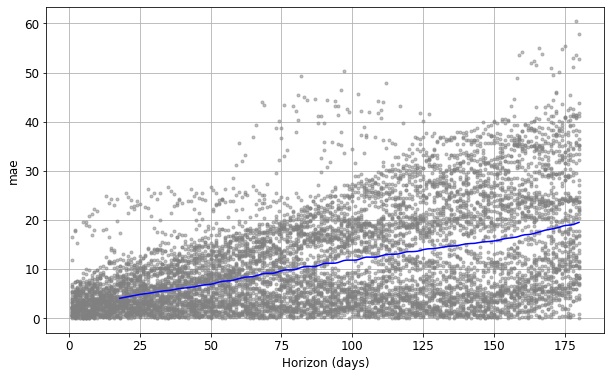

In [18]:
kpi = plot_cross_validation_metric(cv, metric="mae")